In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Charger les jeux de données
jobs_data = pd.read_csv('/kaggle/input/anason/linkedin_jobs.csv')
profiles_data = pd.read_csv('/kaggle/input/anason/upwork_profiles.csv')

# Vérification des colonnes nécessaires et gestion des valeurs manquantes
for df, name in zip([jobs_data, profiles_data], ["jobs", "profiles"]):
    if 'describtion' not in df.columns or df['describtion'].isnull().any():
        raise ValueError(f"Le jeu de données {name} doit contenir une colonne 'describtion' non nulle.")

# Ajout d'IDs uniques si nécessaire
if 'user_id' not in profiles_data.columns:
    profiles_data['user_id'] = np.arange(1, len(profiles_data) + 1)

if 'job_id' not in jobs_data.columns:
    jobs_data['job_id'] = np.arange(1, len(jobs_data) + 1)

# Étape 1 : Calcul de la similarité cosinus
# TF-IDF pour les descriptions des utilisateurs et des emplois
tfidf_jobs = TfidfVectorizer(max_features=100)
job_tfidf_matrix = tfidf_jobs.fit_transform(jobs_data['describtion']).toarray()

tfidf_profiles = TfidfVectorizer(max_features=100)
profile_tfidf_matrix = tfidf_profiles.fit_transform(profiles_data['describtion']).toarray()

# Calcul de similarité entre chaque utilisateur et chaque emploi
similarity_matrix = cosine_similarity(profile_tfidf_matrix, job_tfidf_matrix)

# Conversion de la matrice de similarité en matrice d'interaction binaire
threshold = 0.5  # Seuil pour définir une correspondance
interaction_data = pd.DataFrame(
    np.where(similarity_matrix >= threshold, 1, 0),
    index=profiles_data['user_id'],
    columns=jobs_data['job_id']
)

# Conversion en format long (user_id, job_id, interaction)
interaction_data = interaction_data.reset_index().melt(
    id_vars=['user_id'], 
    var_name='job_id', 
    value_name='interaction'
)

# Étape 2 : Division des données en ensembles d'entraînement et de test
train, test = train_test_split(interaction_data, test_size=0.2, random_state=42)

# Étape 3 : Modèle DeepMF + Basé sur le contenu
# Inputs
user_input = Input(shape=(1,), name='user_input')
job_input = Input(shape=(1,), name='job_input')
user_features_input = Input(shape=(profile_tfidf_matrix.shape[1],), name='user_features')
job_features_input = Input(shape=(job_tfidf_matrix.shape[1],), name='job_features')

# Embeddings pour DeepMF
user_embedding = Embedding(input_dim=len(profiles_data) + 1, output_dim=50, name='user_embedding')(user_input)
job_embedding = Embedding(input_dim=len(jobs_data) + 1, output_dim=50, name='job_embedding')(job_input)

user_vector = Flatten(name='user_vector')(user_embedding)
job_vector = Flatten(name='job_vector')(job_embedding)

# Fusionner les embeddings et les représentations textuelles
concat_embeddings = Concatenate()([user_vector, job_vector])
concat_features = Concatenate()([user_features_input, job_features_input])

# Fusion finale
concat_all = Concatenate()([concat_embeddings, concat_features])

# Fully connected layers
dense_1 = Dense(128, activation='relu')(concat_all)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
output = Dense(1, activation='sigmoid', name='output')(dense_2)

# Compilation du modèle
model = Model(inputs=[user_input, job_input, user_features_input, job_features_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,550 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_embedding       │ (None, 1, 50)     │    168,950 │ job_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_vector         │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_vector          │ (None, 50)        │          0 │ job_embedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_features       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_features        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 100)       │          0 │ user_vector[0][0… │
│ (Concatenate)       │                   │            │ job_vector[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 200)       │          0 │ user_features[0]… │
│ (Concatenate)       │                   │            │ job_features[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 300)       │          0 │ concatenate_6[0]… │
│ (Concatenate)       │                   │            │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     38,528 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 263,349 (1.00 MB)

 Trainable params: 263,349 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1734974061.055298      92 service.cc:145] XLA service 0x7f94cc0088d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734974061.055345      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734974061.055348      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  100/64182 ━━━━━━━━━━━━━━━━━━━━ 1:38 2ms/step - accuracy: 0.9699 - loss: 0.2668

I0000 00:00:1734974063.769738      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64182/64182 ━━━━━━━━━━━━━━━━━━━━ 123s 2ms/step - accuracy: 0.9938 - loss: 0.0210 - val_accuracy: 0.9952 - val_loss: 0.0137
Epoch 2/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.9957 - loss: 0.0130 - val_accuracy: 0.9955 - val_loss: 0.0126
Epoch 3/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9957 - val_loss: 0.0127
Epoch 4/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.9965 - loss: 0.0107 - val_accuracy: 0.9958 - val_loss: 0.0124
Epoch 5/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.9966 - loss: 0.0105 - val_accuracy: 0.9957 - val_loss: 0.0121
Epoch 6/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9960 - val_loss: 0.0126
Epoch 7/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.9960 - val_loss: 0.0117
Epoch 8/10
64182/64182 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.9

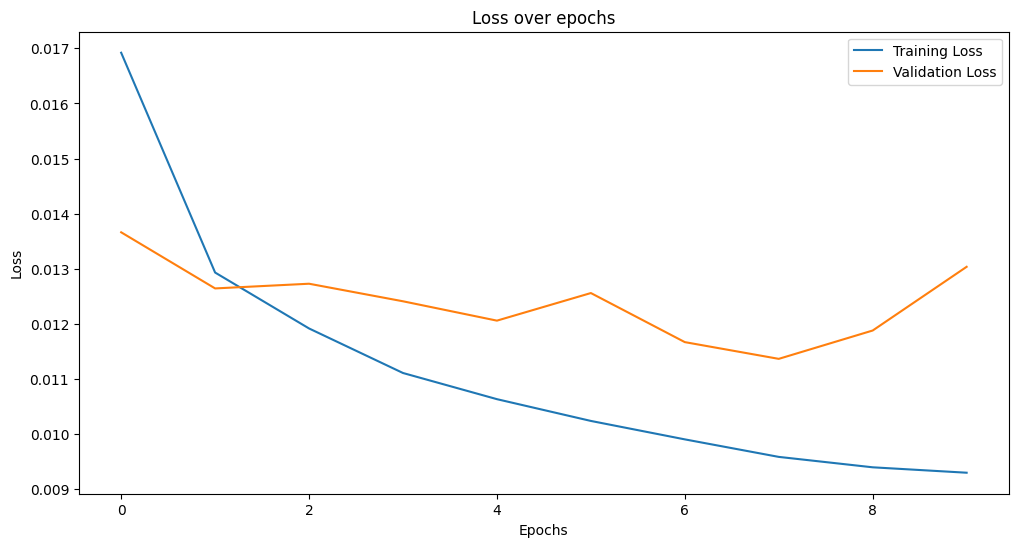

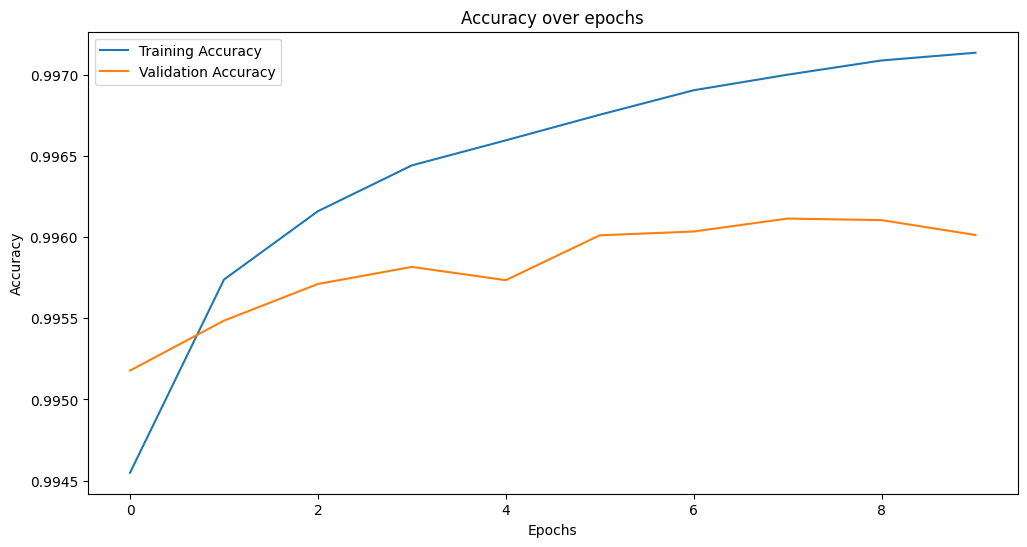

In [4]:
from sklearn.metrics import accuracy_score, classification_report

# Étape 1 : Préparation des données d'entrée
# Remapper les identifiants des utilisateurs et des emplois pour qu'ils soient contigus (nécessaire pour Embedding)
user_id_map = {user_id: idx for idx, user_id in enumerate(profiles_data['user_id'], start=1)}
job_id_map = {job_id: idx for idx, job_id in enumerate(jobs_data['job_id'], start=1)}

train['user_id'] = train['user_id'].map(user_id_map)
train['job_id'] = train['job_id'].map(job_id_map)
test['user_id'] = test['user_id'].map(user_id_map)
test['job_id'] = test['job_id'].map(job_id_map)

# Entrées pour l'entraînement
X_train = [
    train['user_id'].values,
    train['job_id'].values,
    profile_tfidf_matrix[train['user_id'] - 1],  # Représentations utilisateurs
    job_tfidf_matrix[train['job_id'] - 1],      # Représentations emplois
]
y_train = train['interaction'].values

# Entrées pour le test
X_test = [
    test['user_id'].values,
    test['job_id'].values,
    profile_tfidf_matrix[test['user_id'] - 1],  # Représentations utilisateurs
    job_tfidf_matrix[test['job_id'] - 1],      # Représentations emplois
]
y_test = test['interaction'].values

# Étape 2 : Entraînement du modèle
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Étape 3 : Évaluation du modèle
# Prédictions sur l'ensemble de test
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optionnel : Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


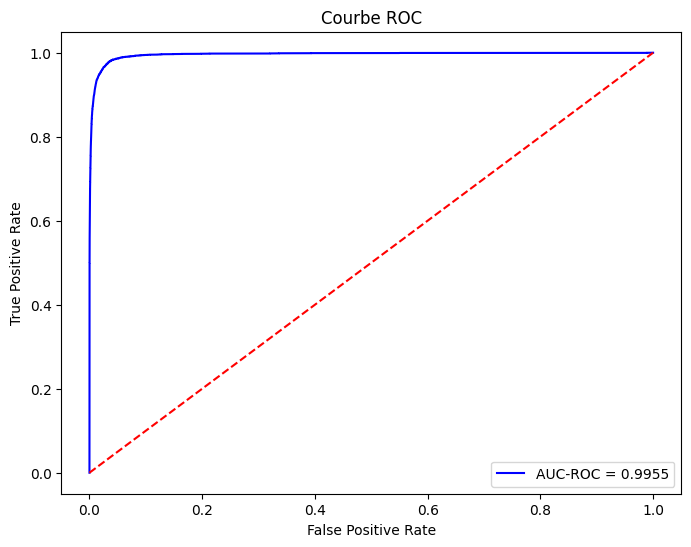

In [6]:
auc_roc = roc_auc_score(y_test, y_pred_probs)

# Optionnel : Visualisation de la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

# Optionnel : Courbe ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Courbe ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [7]:
import numpy as np

# Fonction pour prédire les jobs pour un utilisateur en fonction d'une description
def predict_jobs_for_user(user_description, jobs_data, tfidf_jobs, model):
    # Prétraiter la description utilisateur avec le même vecteur TF-IDF utilisé pour les profils
    user_vector = tfidf_profiles.transform([user_description]).toarray()
    
    # Créer des données d'entrée pour chaque job dans jobs_data
    user_input_data = np.array([0] * len(jobs_data))  # ID utilisateur fictif (0) car c'est un nouvel utilisateur
    job_input_data = jobs_data['job_id'].values  # IDs des emplois
    user_features_data = np.repeat(user_vector, len(jobs_data), axis=0)  # Répéter les features utilisateur
    job_features_data = job_tfidf_matrix  # Features des jobs (TF-IDF)

    # Faire des prédictions
    predictions = model.predict([user_input_data, job_input_data, user_features_data, job_features_data])

    # Ajouter les prédictions dans jobs_data pour afficher les résultats
    jobs_data['match_probability'] = predictions
    jobs_data = jobs_data.sort_values(by='match_probability', ascending=False)

    return jobs_data[['job_id', 'jobs_titles', 'match_probability']].head(5)  # Top 5 des jobs recommandés

# Exemple : Entrée utilisateur
print("Entrez une description de votre profil (exemple : compétences, expérience) :")
user_description = input()

# Prédire les jobs pour cette description utilisateur
recommended_jobs = predict_jobs_for_user(user_description, jobs_data, tfidf_jobs, model)

# Afficher les recommandations
print("\nJobs recommandés pour vous :")
print(recommended_jobs)


Entrez une description de votre profil (exemple : compétences, expérience) :


 Data Scientist avec 3 ans d'expérience en analyse de données et en apprentissage automatique


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Jobs recommandés pour vous :
      job_id                                jobs_titles  match_probability
1128    1129                      Data Science Engineer           0.973814
1786    1787  Senior Azure Data Engineer / Data Modeler           0.949902
1127    1128                      Data Science Engineer           0.943833
1129    1130                      Data Science Engineer           0.917532
422      423                              Data Engineer           0.875038


In [8]:
model.save('job_recommendation_model.h5')